# 0.) Load libraries/datasets

In [1]:
# Load libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

from itertools import product
from os.path import isdir, isfile

import librosa
import librosa.display

from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier as KNN

# Set up datapath
base_path = './datasets/petsounds/cats_dogs/'

if not isdir(base_path):
    print(f"The dataset path {base_path} doesn't seem to exist. Please make sure the path to the data is correct.")
    
# Get dictionary of sounds
cat_file = 'cat_{}.wav'
dog_file = 'dog_barking_{}.wav'

pet_sounds = {'cat': [], 'dog': []}
for i in range(0, 168):
    this_cat = base_path + cat_file.format(i)
    if isfile(this_cat):
        pet_sounds['cat'].append(this_cat)
        
    this_dog = base_path + dog_file.format(i)
    if isfile(this_dog):
        pet_sounds['dog'].append(this_dog)

# 1.) Pre-process a single file using 20 frequency bins, and 2000 Hz sampling frequency.

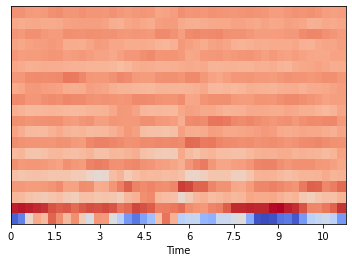

In [2]:
SAMPLING_FRQ = 2000
BINS = 20

# Process the first cat file
x, fs = librosa.load(pet_sounds['cat'][0], sr=SAMPLING_FRQ)
mfccs = librosa.feature.mfcc(x, sr=fs, n_mfcc=BINS)
librosa.display.specshow(mfccs, sr=fs, x_axis='time')

# 2.) Process each into X and Y matrices. Apply a classifier and comment on results.

### Some setup

In [3]:
# Up sampling frequency to 4k
SAMPLING_FRQ = 4000

# Generator function to get all dogs/cats files and label
def get_pet():
    for pet in ['cat', 'dog']:
        for i in range(0, len(pet_sounds[pet])):
            yield(pet_sounds[pet][i], pet)
        
    return None

### Convert all sounds in pet_sounds to waveforms

In [4]:
%%time

spec_pet_sounds = {'cat': [], 'dog': []}
for sound, pet in get_pet():
    wf, _ = librosa.load(sound, sr=SAMPLING_FRQ)
    spec_pet_sounds[pet].append(wf)

# save changes
pet_sounds = spec_pet_sounds

Wall time: 19.3 s


### Pad sound files to max length

In [5]:
"""# determine max length
max_len = 0
for wf, _ in get_pet():
    max_len = len(wf) if len(wf) > max_len else max_len
    
# pad to max length
ext_pet_sounds = {'cat': [], 'dog': []}
for wf, pet in get_pet():

    if len(wf) < max_len:
        padding = max_len - len(wf)
        wf = np.pad(wf, (0, padding))
        
    ext_pet_sounds[pet].append(wf)
    
# save changes
pet_sounds = ext_pet_sounds"""

"# determine max length\nmax_len = 0\nfor wf, _ in get_pet():\n    max_len = len(wf) if len(wf) > max_len else max_len\n    \n# pad to max length\next_pet_sounds = {'cat': [], 'dog': []}\nfor wf, pet in get_pet():\n\n    if len(wf) < max_len:\n        padding = max_len - len(wf)\n        wf = np.pad(wf, (0, padding))\n        \n    ext_pet_sounds[pet].append(wf)\n    \n# save changes\npet_sounds = ext_pet_sounds"

### Get a DataFrame and then Matricies

In [6]:
# Process into Dataframe for personal sanity
pet_sounds_dict = None

for wf, pet in get_pet():
    mfccs = librosa.feature.mfcc(wf, sr=SAMPLING_FRQ, n_mfcc=BINS,  n_fft=1536)
    
    # initialize dictionary if necessary
    if pet_sounds_dict is None:
        pet_sounds_dict = {}
        for i in range(len(mfccs)):
            pet_sounds_dict[f'MFCC_{i}'] = []
        pet_sounds_dict['Class'] = []

    # fill dictionary
    for i in range(len(mfccs)):
        pet_sounds_dict[f'MFCC_{i}'].append(mfccs[i])
    # binarize the Class column
    pet_sounds_dict['Class'].append(0 if pet == 'cat' else 1)

# Make df
pet_sounds_df = pd.DataFrame(pet_sounds_dict)
   
display(pet_sounds_df)

,MFCC_0,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,...,MFCC_11,MFCC_12,MFCC_13,MFCC_14,MFCC_15,MFCC_16,MFCC_17,MFCC_18,MFCC_19,Class
0,"[-258.18738, -284.7407, -312.19196, -268.04465...","[27.861824, 59.56469, 66.32253, 95.97801, 78.8...","[36.387424, 18.370556, 0.26537612, 2.4007998, ...","[13.674143, 6.4087768, 2.136726, 8.049694, 6.5...","[-26.66286, -20.455076, -16.730259, -18.138733...","[6.6568437, 0.62998563, -0.8300344, -9.509359,...","[-22.43832, -21.745865, -18.589762, -22.72855,...","[-2.782512, -2.8020754, 1.9728485, -9.913216, ...","[-5.165763, -11.712496, -16.808056, -30.71688,...","[-5.5294414, -2.7261553, 4.855996, -0.70777553...",...,"[-6.884987, -2.7222743, -2.3383965, -3.4082336...","[-9.323173, -7.45903, -5.784301, -12.265175, -...","[14.706234, 12.095408, 13.345386, -2.4056582, ...","[-9.363182, -7.089628, 1.7237304, -15.149206, ...","[8.927959, 3.599165, 2.3340871, 2.9440196, 5.2...","[-8.314947, -12.525179, -13.833056, -10.018965...","[9.032004, 1.080277, 4.3630085, -3.270485, -0....","[-9.178306, -7.0866346, -6.6824846, -10.727777...","[8.111672, 7.0315957, 4.7069025, 10.407851, 7....",0
1,"[-163.5705, -100.56007, -135.47318, -148.52199...","[61.222656, -23.008743, -32.525047, -32.161083...","[6.640017, 9.915731, -3.423748, 3.1722598, 25....","[9.502436, 5.4180803, -4.3007255, -6.272064, -...","[-27.294802, -42.718895, -26.026764, -31.91894...","[-20.578884, 17.370733, 45.752785, 38.994797, ...","[15.525398, 36.23007, 22.03366, 50.49366, -1.3...","[9.702053, -13.790918, -45.81321, -69.393295, ...","[-33.904953, -35.258644, -24.146194, -20.93142...","[2.2391467, -9.798603, 3.8899927, 17.980148, 4...",...,"[-8.101151, -11.871994, -11.108414, 33.646164,...","[-6.102394, -2.1080496, 2.6024191, -9.570055, ...","[11.114502, 19.684006, 12.4468155, 6.228718, -...","[-9.681355, -10.606749, -4.888302, -15.448138,...","[-22.742222, -25.446495, -11.283389, 7.9518967...","[-4.2776747, -13.335861, -14.275513, -20.97976...","[-4.2340775, 9.358123, 21.362215, 30.529877, 1...","[-8.795037, -10.301868, -15.34639, -13.99262, ...","[7.1614513, 6.0857987, 8.5601635, 4.2054343, -...",0
2,"[-274.46756, -297.07883, -316.15775, -309.5955...","[100.858284, 94.95245, 79.75273, 84.74603, 75....","[5.0394154, 8.067383, 9.073028, 15.275961, 6.3...","[5.725365, 15.377333, 21.493473, 28.551344, 15...","[-4.236589, -3.644557, -8.284432, -6.995346, -...","[14.022707, 13.998716, 7.2421985, 7.5216, 5.89...","[-4.0310287, -6.5710664, -6.353795, -5.1770954...","[-20.490124, -5.5586443, 2.9035964, 4.7915564,...","[-18.580952, -18.158031, -12.024481, -10.35654...","[-9.416017, -0.81526256, 0.004240334, 0.61111,...",...,"[-4.17904, 2.0928624, 2.4403956, 4.4621077, 6....","[-15.465732, -9.043976, -1.7650328, -3.5093656...","[-8.621484, 1.7375443, 10.768354, 14.571271, 1...","[-5.3912306, -6.0441732, -8.612839, -13.007977...","[-3.7914677, -0.0910542, 0.63953185, -3.016583...","[-4.6339846, -6.140554, -9.9861145, -12.17164,...","[4.5717726, 5.0589504, 8.4412155, 3.8832755, 6...","[-7.092595, -10.361078, -8.219275, -10.938367,...","[-2.9487257, 3.3204236, 0.8706946, 1.264533, 5...",0
3,"[-305.95465, -197.5452, -60.079998, -71.2381, ...","[88.36915, 63.135475, -12.104095, -20.622892, ...","[17.8003, 7.5580482, -12.292658, 0.15277052, 3...","[20.276155, 24.079727, 21.576113, 10.706543, -...","[-2.4615178, 4.3189783, 21.959412, 25.051437, ...","[0.05768706, -1.5123074, 14.058336, 11.479834,...","[-11.773218, -10.387426, 10.902386, 38.194977,...","[3.2567773, 1.8392146, -22.101635, -47.56465, ...","[-11.5407295, -25.29744, -14.377451, 1.2634127...","[7.920136, 5.1687827, -9.384288, -14.785379, 8...",...,"[-1.4409091, 8.654516, 29.948076, 47.229027, 6...","[-9.256832, -13.73356, -20.073452, -16.830395,...","[15.531233, 4.8227654, -15.781818, -18.308298,...","[-9.144295, -9.142951, -6.206385, -5.2939777, ...","[-5.840032, 7.7152348, 5.4812393, -0.31716692,...","[-5.073171, -5.9924345, 15.278574, 15.668169, ...","[1.788081, 2.1826825

In [7]:
total_length = 0

for lst in pet_sounds_df['MFCC_0']:
    total_length += len(lst)
    
print(total_length)    

15144


In [8]:
# Now actually make matricies (am dummy and couldn't get this right without a Dataframe)
X = pet_sounds_df.loc[:, pet_sounds_df.columns != 'Class'].values
Y = pet_sounds_df.loc[:, pet_sounds_df.columns == 'Class'].values.ravel()

print(len(X[0][0]))

X_flat = []
for x in X:
    tmpx = []
    for xsub in x:
        tmpx += list(xsub)
        
    X_flat.append(tmpx)

X = np.array(X_flat)

print(X.shape)
print(Y.shape)

88
(277,)
(277,)


<ipython-input-8-2d7ab0378ddd>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X = np.array(X_flat)


### Do some sklearn

In [9]:
# Define models
JOBS = 6
SCORING = 'accuracy'
REFIT = 'accuracy'

# model params
SVC_params = {'kernel': ['linear', 'poly', 'rbf'],
              'C': [i for i in range(5, 16)]}

RFC_params = {'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 5],
              'ccp_alpha': [0.0001, 0.001, 0.01, 0.1]}

KNN_params = {'n_neighbors': [i for i in range(10, 21)],
              'weights': ['uniform', 'distance']}

models = [GridSearchCV(SVC(), SVC_params, scoring=SCORING, refit=REFIT, n_jobs=JOBS),
          GridSearchCV(RFC(n_jobs=JOBS), RFC_params, scoring=SCORING, refit=REFIT, n_jobs=JOBS),
          GridSearchCV(KNN(n_jobs=JOBS), KNN_params, scoring=SCORING, refit=REFIT, n_jobs=JOBS)]

In [10]:
# Run GridSearchCV

for model in models:
    model = model.fit(X, Y)
    print(f'Model -- {model}')
    print(f'\tBest estimator: {model.best_estimator_}')
    print(f'\tBest score: {model.best_score_}')

ValueError: setting an array element with a sequence.